In [1]:
%matplotlib inline
from spectral_density_functions import S_k_omega, convolve, S_k_omega_conv, Skw_nLTE_stray_light_convolve, Z_nLTE
import matplotlib.pyplot as plt
import numpy as np
from lmfit.models import VoigtModel
from lmfit import Model

In [23]:
l=np.linspace(531,533,2000)*1e-9 #generate an array of wavelengths in nm
l0=532e-9#central wavelength
vm=VoigtModel()#Borrow a Voigt profile from the lmfit package to use as our response function
#Response centered on l0, width 0.16 Angstrom as experimentally measured. 
#To view the unconvolved spectrum, I suggest reducing sigma to 1e-13.
response=vm.eval(x=l, center=l0,gamma=1.41e-11, sigma=1.27e-11,amplitude=1.0)

'''Plasma Parameters'''
n_e=1e18#cm^-3
A=12#Ion mass
T_i=50#in eV
T_e=10#in eV
Z=Z_nLTE(T_e, np.genfromtxt('zb_Spk_C_NLTE.txt', delimiter='       ', skip_header=4))

In [73]:
a=11
V0=50e3

circ_coords=[]

for y in range(-a,a+1):
    for x in range(-a,a+1):
        if x**2+y**2<=a**2:
            circ_coords.append((x,y))
            
vel_rigid=[]
for c in circ_coords:
    r=np.sqrt(c[0]**2+c[1]**2)
    th=np.arctan2(c[0],c[1])
    vx=V0*r/a*np.cos(th)
    vy=V0*r/a*np.sin(th)
    vel_rigid.append((vx,vy))
    
vel_shear=[]
vy_mean=0
for c in circ_coords:
    vx=0
    vy=V0*(0.5-np.abs(c[1]/a))
    vy_mean+=vy
    vel_shear.append((vx,vy))
    
vel=vel_shear
vy_mean=vy_mean/len(vel_shear)

V0=200e3
vel=np.array([[0,V0*(1-np.abs(x/a))] for x in range(-a+1,a+1)])

In [74]:
skw_45=np.zeros_like(l)
skw_135=np.zeros_like(l)

skw_45_0=S_k_omega(l,lambda_in=l0, theta=45,A=A,T_e=T_e,T_i=T_i,n_e=n_e,Z=Z, v_fi=0)
skw_135_0=S_k_omega(l,lambda_in=l0, theta=135,A=A,T_e=T_e,T_i=T_i,n_e=n_e,Z=Z, v_fi=0)

for v in vel:
    skw_45=skw_45+S_k_omega(l,lambda_in=l0, theta=45,A=A,T_e=T_e,T_i=T_i,n_e=n_e,Z=Z, v_fi=v[0])
    skw_135=skw_135+S_k_omega(l,lambda_in=l0, theta=135,A=A,T_e=T_e,T_i=T_i,n_e=n_e,Z=Z, v_fi=v[1]-np.mean(vel[:,1]))

    
skw_45=convolve(response,skw_45)
skw_45_0=convolve(response,skw_45_0)
skw_135=convolve(response,skw_135)
skw_135_0=convolve(response,skw_135_0)

def norm(array):
    return array/array.max()

skw_45=norm(skw_45)
skw_45_0=norm(skw_45_0)
skw_135=norm(skw_135)
skw_135_0=norm(skw_135_0)

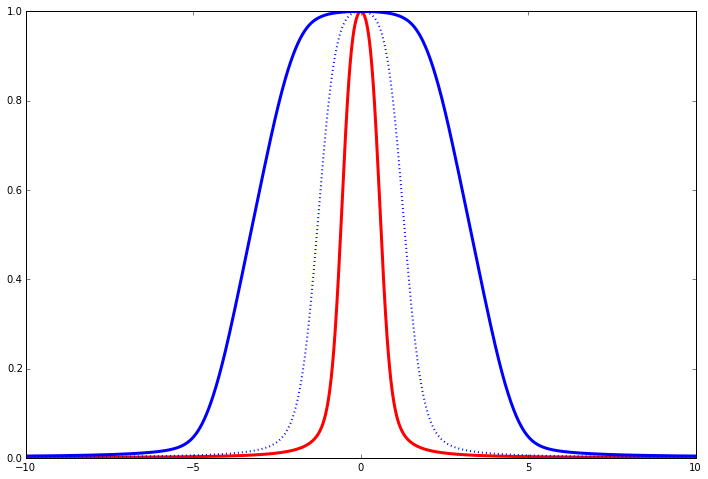

In [75]:
shift=(l-l0)*1e10
fig, ax=plt.subplots(figsize=(12,8))
ax.plot(shift, skw_45, lw=3, color='red')
ax.plot(shift, skw_45_0, ls=':', lw=2, color='red')
ax.plot(shift, skw_135, lw=3, color='b')
ax.plot(shift, skw_135_0, ls=':', lw=2, color='b')

In [76]:
iv_dict={} #dictionary for independent variables
#sort into dictionaries based on another dictionary
iv_dict['lambda_range']=l
iv_dict['lambda_in']=l0
iv_dict['response']=response    
iv_dict['theta']=45
iv_dict['Aj']=A
iv_dict['n_e']=n_e
iv_dict['V_fe']=0
iv_dict['V_fi1']=0
iv_dict['stry']=0
iv_dict['amp']=1
iv_dict['offset']=0
iv_dict['shift']=0
iv_dict['Z_Te_table']=np.genfromtxt('zb_Spk_C_NLTE.txt', delimiter='       ', skip_header=4)

s45=Model(Skw_nLTE_stray_light_convolve, independent_vars=iv_dict.keys()) #create our model with our set variables.

s45.set_param_hint('T_i1', value = T_i)
s45.set_param_hint('T_e', value = T_e)

s45_res=s45.fit(skw_45, **iv_dict)
print(s45_res.fit_report())

iv_dict['theta']=135

s135=Model(Skw_nLTE_stray_light_convolve, independent_vars=iv_dict.keys()) #create our model with our set variables.

s135.set_param_hint('T_i1', value = T_i)
s135.set_param_hint('T_e', value = 40)

s135_res=s135.fit(skw_135, **iv_dict)
print(s135_res.fit_report())

 - Adding parameter for hint "T_i1"
 - Adding parameter for hint "T_e"
 - Adding parameter "T_e"
 - Adding parameter "T_i1"
[[Model]]
    Model(Skw_nLTE_stray_light_convolve)
[[Fit Statistics]]
    # function evals   = 9
    # data points      = 2000
    # variables        = 2
    chi-square         = 0.000
    reduced chi-square = 0.000
[[Variables]]
    T_i1:   49.9938373 +/- 0.001240 (0.00%) (init= 50)
    T_e:    9.99815898 +/- 0.000160 (0.00%) (init= 10)
[[Correlations]] (unreported correlations are <  0.100)
    C(T_i1, T_e)                 = -0.805 

 - Adding parameter for hint "T_i1"
 - Adding parameter for hint "T_e"
 - Adding parameter "T_e"
 - Adding parameter "T_i1"
[[Model]]
    Model(Skw_nLTE_stray_light_convolve)
[[Fit Statistics]]
    # function evals   = 61
    # data points      = 2000
    # variables        = 2
    chi-square         = 2.291
    reduced chi-square = 0.001
[[Variables]]
    T_i1:   364.402643 +/- 2.962982 (0.81%) (init= 50)
    T_e:    105.099828 +/-

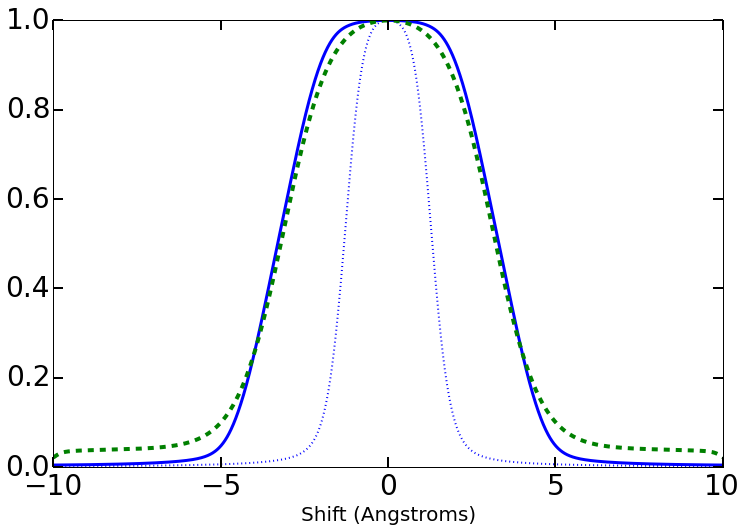

In [77]:
shift=(l-l0)*1e10
fig, ax=plt.subplots(figsize=(12,8))
#ax.plot(shift, skw_45, lw=3, color='red')
#ax.plot(shift, skw_45_0, ls=':', lw=2, color='red')
#ax.plot(shift, s45_res.best_fit, ls='--', lw=4, color='black')
ax.plot(shift, skw_135, lw=3, color='b')
ax.plot(shift, skw_135_0, ls=':', lw=2, color='b')
ax.plot(shift, s135_res.best_fit, ls='--', lw=4, color='green')
ax.set_xlabel('Shift (Angstroms)', fontsize=20)
ax.tick_params(labelsize=28, pad=5, length=10, width=2)


In [56]:
Z_nLTE(s135_res.best_values['T_e'], iv_dict['Z_Te_table'])*s135_res.best_values['T_e']+s135_res.best_values['T_i1']

KeyError: 'T_e'

In [57]:
Z

3.8531655200000001

In [53]:
fig.savefig('TS shear flow investigation.png')

In [65]:
np.mean(vel[:,1])

49999.999999999993